<a href="https://colab.research.google.com/github/woo-ara/TIL/blob/main/DCGAN2_%EC%9D%B4%EB%AF%B8%EC%A7%80%EC%A0%80%EC%9E%A5_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 7995
# manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

np.random.seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
cudnn.benchmark = False
cudnn.deterministic = True

Random Seed:  7995


In [ ]:
#dataroot = "/content/drive/MyDrive/dataset_patch_220117/train"
dataroot = "/content/drive/MyDrive/dataset_cyst" #cyst 데이터셋만
#dataroot = "/content/drive/MyDrive/dataset_meta" #meta 데이터셋만
#dataroot = "/content/drive/MyDrive/dataset_hema" #hema 데이터셋만
workers = 2 #데이터 불러올 때 사용할 쓰레드 개수
batch_size = 16
image_size = 64
nc = 3 #색 채널 개수 (RGB)
nz = 100 #벡터 원소개수
ngf = 64
ndf = 64
num_epochs = 300
lr = 0.0002 #2e-4=0.0002, 1e-4=0.001
beta1 = 0.5 #Adam optimizer 하이퍼파라미터 값. 논문처럼 0.5
ngpu = 1

In [ ]:
#데이터셋 만들기
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size), #가운데 부분을 image_size로 자름
                               transforms.ToTensor(), #이미지 데이터를 tensor로 바꿈
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #정규화
                           ]))
# dataloader 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# GPU 사용여부
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
classes = dataset.classes
classes

['cyst']

In [ ]:
# 정규화 확인
# import PIL
# img = PIL.Image.open('/content/drive/MyDrive/dataset_patch_220117/train/cyst/train_00001.jpg')
# img.show()
# #print((np.transpose(img, (1,2,1))).shape)
# print(img)

# example of pixel normalization
from numpy import asarray
from PIL import Image
# load image
image = Image.open('/content/drive/MyDrive/dataset_patch_220117/train/cyst/train_00002.jpg')
pixels = asarray(image)
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))


Data Type: uint8
Min: 15.000, Max: 237.000
Min: 0.059, Max: 0.929


In [ ]:
print(dataset.__getitem__(13))

(tensor([[[-1.0000, -0.9686, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9686, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.8667, -0.8824, -0.9137,  ...,  0.9843,  0.9137,  0.8667],
         [-1.0000, -0.9765, -0.9843,  ...,  0.8667,  0.8118,  0.7725],
         [-0.9765, -0.8745, -0.8431,  ...,  0.6471,  0.5686,  0.5294]],

        [[-1.0000, -0.9686, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9686, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.8667, -0.8824, -0.9137,  ...,  0.9843,  0.9137,  0.8667],
         [-1.0000, -0.9765, -0.9843,  ...,  0.8667,  0.8118,  0.7725],
         [-0.9765, -0.8745, -0.8431,  ...,  0.6471,  0.5686,  0.5294]],

        [[-1.0000, -0.9686, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -

In [ ]:
len(dataset)

433

In [ ]:
# from torchsummary import summary

# batch_iterator = iter(dataloader)
# images = next(batch_iterator)

# print(images.size())

In [ ]:
# example of pixel normalization
from numpy import asarray
from PIL import Image

# load image
image = Image.open('/content/drive/MyDrive/dataset_patch_220117/train/cyst/train_00002.jpg')
pixels = asarray(image)

# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

# # convert from integers to floats
# pixels = pixels.astype('float32')

# # normalize to the range 0-1
# #pixels /= 255.0
# pixels.tfidf.transforms.ToTensor()


# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 15.000, Max: 237.000
Min: 15.000, Max: 237.000


In [ ]:
# seed값 확인
dataiter = iter(dataloader)
images, labels = dataiter.next()
print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
for batch_size, (inputs, labels) in enumerate(dataloader):
  print(inputs.size())
  print("{} batch \n inputs[0][0][0][0] : {} \n labels: {}".format(batch_size, inputs[0][0][0][0], labels))
  #print("{} batch \n inputs[0][0][0][0]".format(batch_size))
  if batch_size ==2:
    break

torch.Size([16, 3, 64, 64])
0 batch 
 inputs[0][0][0][0] : 0.027451038360595703 
 labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([16, 3, 64, 64])
1 batch 
 inputs[0][0][0][0] : 0.3176470994949341 
 labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([16, 3, 64, 64])
2 batch 
 inputs[0][0][0][0] : 0.2862745523452759 
 labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# 화면에 이미지 몇 개 띄우기
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2, normalize=True).cpu(),(1,2,0)))
#nrow=3, 

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
#nn.ConvTranspose2d(input의 채널수, output의 채널 수, kernel size, stride, padding)

In [ ]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)
    
    # def predict(self, x): 
    #     x = self.forward(x) 
    #     return x




#### 이미지 저장 #####
    # def __getitem__(self, idx):
    #     bs = self.batch_size
    #     batch_X, batch_Y = self.__load(idx, bs)
  
    #     b = img_list.shape[0]
        
    #     for j in range(b):
    #             img = img_list[j][:,:,:]
    #             lb = img_list[j][:]
    #             img_2= Image.fromarray((img * 255).astype(np.uint8))
    #             if lb[0] == 1:
    #                 img_2.save('/content/Result/%s_cyst_augmix.jpg' %(n1),'JPEG')
    #                 n1+=1
    #             elif lb[1] == 1:
    #                 img_2.save('/content/Result/%s_hem_augmix.jpg' %(n1),'JPEG')
    #                 n1+=1
    #             else:
    #                 img_2.save('/content/Result/%s_met_augmix.jpg' %(n1),'JPEG')
    #                 n1+=1

In [ ]:
netG = Generator(ngpu).to(device)

# multi-gpu 필요하면 설정
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# BCELoss 함수의 인스턴스 생성
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성 (Generator의 학습 과정 추적 위해)
fixed_noise = torch.randn(1, nz, 1, 1, device=device) # 64

# 학습에 사용되는 참/거짓의 라벨
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam optimizer를 생성
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
import torchvision

In [ ]:
img_list = []
# img_list2 = []
# img_list3 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch (진짜 데이터들로 학습)
        netD.zero_grad()
        # Format batch (배치사이즈, 사용할 디바이스에 맞게 조정)
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D (진짜 데이터들로 이루어진 배치를 D에 통과)
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch(손실값 구함)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass (역전파 과정에서 변화도 계산)
        errD_real.backward()
        D_x = output.mean().item()


        ## Train with all-fake batch (가짜 데이터들로 학습)
        # Generate batch of latent vectors (벡터 생성)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G (G로 가짜 이미지 생성)
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D (D로 판별)
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch (D 손실값 계산)
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients(역전파로 변화도 계산 후 앞의 변화도에 더하기)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches (가짜 이미지, 진짜 이미지 손실값 모두 더함)
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        


        ############################
        # (2) Update G network: maximize log(D(G(z))) (G 신경망 업데이트)
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost (생성자 손실값 구하기 위해 진짜 라벨 이용)
        # Since we just updated D, perform another forward pass of all-fake batch through D (D가 방금 업데이트 됐기 때문에 다시 D에 가짜 데이터 통과)
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output (G 손실값 구하기)
        errG = criterion(output, label)
        # Calculate gradients for G (G 변화도 계산)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # 훈련상태 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]tLoss_D: %.4f tLoss_G: %.4f tD(x): %.4f tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # 그래프 위해 손실값 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        
        # fixed_noise 통과시킨 G의 출력값 저장
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, nrow=1, normalize=True))

        # # 이미지 저장용
        # if (iters % 1 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list3.append(vutils.make_grid(fake, padding=2, nrow=1, normalize=True))

            ########################
            #이미지 저장

            # torchvision.utils.save_image(fake, os.path.join('Result/image_at_iter_{:04d}.png'.format(i)))

            # latent_vectors = np.random.normal(0.0, 1.0, [150, 64])
            # fake_images = Generator.predict(latent_vectors) #데이터 넣어 결과 예측

            # x = Image.fromarray(np.uint8(fake_images[i]*255)).convert('L') 
            # x.save('Result/image_at_iter_{:04d}.png'.format(i))
            ########################
        #torchvision.utils.save_image(fake, os.path.join('Result/image_at_iter_{:04d}.png'.format(i)))  #마지막 주석 
        iters += 1  

    # if num_epochs == num_epochs:
    #   img_list2.append(vutils.make_grid(fake, padding=2, nrow=1, normalize=True))

          #torchvision.utils.save_image(fake, os.path.join('Result/image_at_iter_{:04d}.png'.format(i)))
        

Starting Training Loop...
[1/300][0/28]tLoss_D: 1.7378 tLoss_G: 7.9941 tD(x): 0.6647 tD(G(z)): 0.6717 / 0.0005
[2/300][0/28]tLoss_D: 0.4448 tLoss_G: 15.8569 tD(x): 0.9755 tD(G(z)): 0.2790 / 0.0000
[3/300][0/28]tLoss_D: 1.0975 tLoss_G: 30.1399 tD(x): 0.6172 tD(G(z)): 0.0000 / 0.0000
[4/300][0/28]tLoss_D: 4.0935 tLoss_G: 28.2249 tD(x): 0.9989 tD(G(z)): 0.9394 / 0.0000
[5/300][0/28]tLoss_D: 0.0018 tLoss_G: 34.4564 tD(x): 0.9983 tD(G(z)): 0.0000 / 0.0000
[6/300][0/28]tLoss_D: 3.0261 tLoss_G: 34.1987 tD(x): 0.9953 tD(G(z)): 0.8639 / 0.0000
[7/300][0/28]tLoss_D: 0.0002 tLoss_G: 39.6067 tD(x): 0.9998 tD(G(z)): 0.0000 / 0.0000
[8/300][0/28]tLoss_D: 0.0001 tLoss_G: 40.2505 tD(x): 0.9999 tD(G(z)): 0.0000 / 0.0000
[9/300][0/28]tLoss_D: 0.0009 tLoss_G: 39.7890 tD(x): 0.9991 tD(G(z)): 0.0000 / 0.0000
[10/300][0/28]tLoss_D: 0.0006 tLoss_G: 40.3100 tD(x): 0.9994 tD(G(z)): 0.0000 / 0.0000
[11/300][0/28]tLoss_D: 0.0000 tLoss_G: 39.8657 tD(x): 1.0000 tD(G(z)): 0.0000 / 0.0000
[12/300][0/28]tLoss_D: 0.00

In [ ]:
len(img_list)

29

In [ ]:
'''
img10 = img_list[25][2]
b10 = img10.cpu().numpy()
img100= Image.fromarray((b10 * 255).astype(np.uint8))
img100.save('/content/test2.jpg','JPEG')
'''

In [ ]:
#all
from PIL import Image
img_list_len=len(img_list)

# img_list 저장 : jpg로
for i in range(img_list_len):
    img10 = img_list[i][2]
    b10 = img10.cpu().numpy()
    img100= Image.fromarray((b10 * 255).astype(np.uint8))
    img100.save('/content/dcgan_cyst_Result_500_1030_all/DCGAN_cyst_%s.jpg' %(i),'JPEG')

In [ ]:
#cyst 433개만
from PIL import Image
img_list_len=len(img_list)

# img_list 저장 : jpg로
for i in range(3897, img_list_len):
    img10 = img_list[i][2]
    b10 = img10.cpu().numpy()
    img100= Image.fromarray((b10 * 255).astype(np.uint8))
    img100.save('/content/dcgan_cyst_Result_500_1030_433/DCGAN_cyst_%s.jpg' %(i-3897),'JPEG')

In [ ]:
# ================================================

In [ ]:
img_list_len=len(img_list)

# img_list 저장 : jpg로
for i in range(img_list_len):
  for j in range(3):
      img10 = img_list[i][j]
      b10 = img10.cpu().numpy()
      img100= Image.fromarray((b10 * 255).astype(np.uint8))
      img100.save('/content/dcgan_cyst_Result_1/DCGAN_cyst_%s_%s.jpg' %(i, j),'JPEG')
      # n1+=1

In [ ]:
!zip -r /content/dcgan_cyst_Result_1.zip /content/dcgan_cyst_Result_1/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_869_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2074_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_957_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2439_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2267_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1060_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1541_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1840_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1280_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2264_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_971_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_142_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1497_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Res

In [ ]:
from google.colab import files
files.download('/content/dcgan_cyst_Result_1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# img_list 저장 : png로
for i in range(img_list_len):
  for j in range(3):
      img10 = img_list[i][j]
      b10 = img10.cpu().numpy()
      img100= Image.fromarray((b10 * 255).astype(np.uint8))
      img100.save('/content/png_dcgan_cyst_Result_1/DCGAN_cyst_%s_%s.png' %(i, j),'PNG')
      # n1+=1

In [ ]:
!zip -r /content/png_dcgan_cyst_Result_1.zip /content/png_dcgan_cyst_Result_1/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_456_2.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_2537_1.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_1974_2.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_2009_1.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_2503_1.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_709_1.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_1838_2.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_581_2.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_1217_0.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_368_2.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_634_0.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_393_0.png (stored 0%)
  adding: content/png_dcgan_cyst_Result_1/DCGAN_cyst_1412_

In [ ]:
from google.colab import files
files.download('/content/png_dcgan_cyst_Result_1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

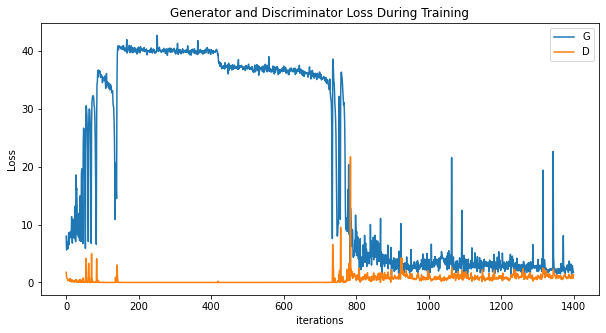

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
##################################

In [ ]:
img_list2

In [ ]:
len(img_list2)

300

In [ ]:
#img2 = img_list2[-1][-1]

In [ ]:
#img2.shape

torch.Size([64, 64])

In [ ]:
# print(img2)

In [ ]:
#b = img2.numpy()

In [ ]:
# print(b)

In [ ]:
#img2= Image.fromarray((b * 255).astype(np.uint8))


In [ ]:
#img2.save('/content/Result/%s_cyst_img2.jpg' %(1),'JPEG')

In [ ]:
#######
# img1 = img_list2[-1]

In [ ]:
# img1.shape

torch.Size([3, 64, 64])

In [ ]:
# a = img1.numpy()

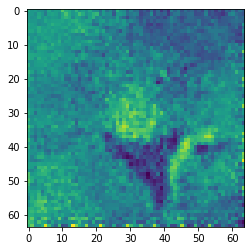

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as img

# #image = img.imread('lena.jpg')
# plt.imshow(b)
# plt.show()

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow

# cv2_imshow(b) # 불러온 이미지를 Lenna라는 이름으로 창 표시.

In [ ]:
#img3 = img_list2[-1][-1][-1]

In [ ]:
#img3.shape

torch.Size([64])

In [ ]:
#####################

In [ ]:
# img10 = img_list[-1][-1]
# b10 = img10.numpy()

In [ ]:
dd

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

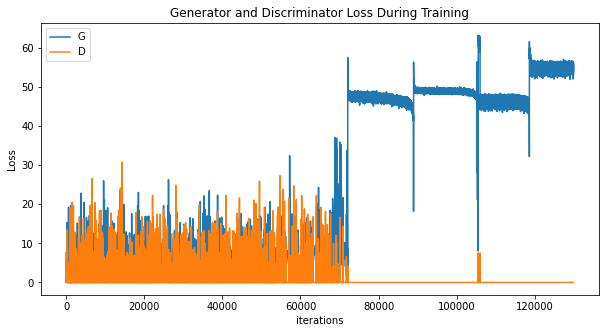

In [ ]:
#############################

In [ ]:
len(img_list2)

300

In [ ]:
len(img_list2[2][-1])

64

In [ ]:
img_list_len2=len(img_list2[2][-1])

In [ ]:
# img_list2 저장
for i in range(img_list_len2):
  for j in range(3):
      img10 = img_list2[i][j]
      b10 = img10.cpu().numpy()
      img100= Image.fromarray((b10 * 255).astype(np.uint8))
      img100.save('/content/dcgan_cyst_Result_2/DCGAN_cyst_%s_%s.jpg' %(i, j),'JPEG')
      # n1+=1

In [ ]:
#####################

In [ ]:
output

tensor([0.0089], device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
dataloader

In [ ]:
fake.shape

torch.Size([1, 3, 64, 64])

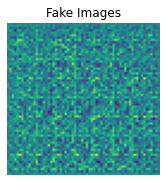

In [ ]:
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[1][1]))
plt.show()

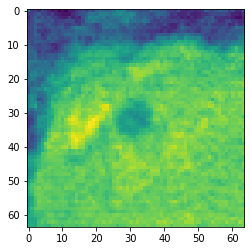

In [ ]:
plt.imshow(img_list[-1][-1])

In [ ]:
output

tensor([0.0089], device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
len(img_list)

2599

In [ ]:
img_list[-1]

tensor([[[0.3382, 0.1487, 0.1200,  ..., 0.1623, 0.1657, 0.2715],
         [0.1808, 0.2356, 0.1564,  ..., 0.0720, 0.0742, 0.1540],
         [0.1124, 0.2643, 0.2364,  ..., 0.0891, 0.0193, 0.1492],
         ...,
         [0.5587, 0.6054, 0.5940,  ..., 0.8127, 0.7784, 0.8027],
         [0.5766, 0.5927, 0.5722,  ..., 0.8057, 0.7976, 0.7605],
         [0.6141, 0.6245, 0.6195,  ..., 0.7552, 0.7755, 0.7855]],

        [[0.3725, 0.1647, 0.1341,  ..., 0.1252, 0.1504, 0.2774],
         [0.1345, 0.2598, 0.2189,  ..., 0.1777, 0.0942, 0.1696],
         [0.1830, 0.2243, 0.2665,  ..., 0.0538, 0.0656, 0.1428],
         ...,
         [0.5270, 0.5896, 0.5653,  ..., 0.7618, 0.8193, 0.7855],
         [0.5905, 0.6119, 0.5728,  ..., 0.8519, 0.7454, 0.8020],
         [0.5990, 0.6079, 0.5993,  ..., 0.7553, 0.7657, 0.7763]],

        [[0.3523, 0.1564, 0.1790,  ..., 0.1177, 0.1378, 0.2701],
         [0.1658, 0.1879, 0.2360,  ..., 0.0957, 0.0749, 0.1711],
         [0.1085, 0.2194, 0.3046,  ..., 0.0446, 0.0346, 0.

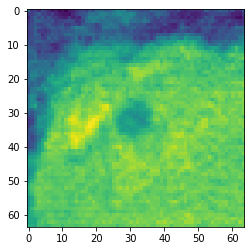

In [ ]:
from torchvision import datasets, transforms
tf = transforms.ToPILImage()
img = tf(img_list[-1][-1])
plt.imshow(img)

In [ ]:
a = np.array(img_list)
print(a)

[tensor([[[0.5168, 0.4123, 0.5033,  ..., 0.4183, 0.4901, 0.4857],
          [0.4820, 0.5562, 0.4771,  ..., 0.4865, 0.5001, 0.4350],
          [0.5039, 0.4002, 0.3480,  ..., 0.4105, 0.4096, 0.5016],
          ...,
          [0.4916, 0.5697, 0.4185,  ..., 0.4331, 0.4638, 0.4496],
          [0.5439, 0.4015, 0.4029,  ..., 0.4694, 0.4849, 0.4629],
          [0.4923, 0.5019, 0.4399,  ..., 0.4713, 0.4757, 0.4700]],

         [[0.5322, 0.5349, 0.5575,  ..., 0.5062, 0.5431, 0.4927],
          [0.5851, 0.4847, 0.5427,  ..., 0.4262, 0.4379, 0.5433],
          [0.5524, 0.4411, 0.4139,  ..., 0.5149, 0.4258, 0.5073],
          ...,
          [0.5561, 0.5434, 0.4689,  ..., 0.5360, 0.4838, 0.4660],
          [0.4970, 0.4556, 0.3675,  ..., 0.5409, 0.4344, 0.4740],
          [0.5292, 0.5080, 0.4976,  ..., 0.4834, 0.4781, 0.4876]],

         [[0.4982, 0.5300, 0.4794,  ..., 0.5253, 0.4773, 0.4994],
          [0.4730, 0.5633, 0.4663,  ..., 0.5376, 0.5047, 0.4853],
          [0.5126, 0.4771, 0.4668,  ..., 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
len(img_list[-1])

3

In [ ]:
a.shape

(2599,)

In [ ]:
#plt.imshow(a)

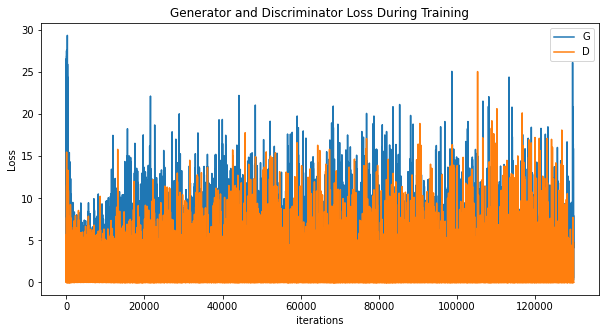

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Animation size has reached 20987299 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images (진짜 이미지 화면 출력)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# Plot the fake images from the last epoch (가짜 이미지 화면 출력)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
#len(img_list[55][-1])

In [ ]:
#img_list[55][-1]

Streaming output truncated to the last 5000 lines.
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_869_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2074_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_957_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2439_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2267_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1060_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1541_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1840_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1280_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_2264_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_971_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_142_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_1/DCGAN_cyst_1497_2.jpg (stored 0%)
  adding: content

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/dcgan_cyst_Result_2.zip /content/dcgan_cyst_Result_2/

  adding: content/dcgan_cyst_Result_2/ (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_60_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_44_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_59_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_24_1.jpg (deflated 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_48_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_63_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_0_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_43_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_26_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_47_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_15_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_20_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_2/^HDCGAN_cyst_6_1.jpg (stored 0%)
  adding: con

In [ ]:
from google.colab import files
files.download('/content/dcgan_cyst_Result_2.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
###########################

In [ ]:
def data_imshow(img):
  img = img.numpy()
  plt.imshow(np.transpose(img, (1,2,0)))
  plt.imshow()

In [ ]:
def process():
  for batch_size, (input, targets) in enumerate(dataloader):
    data_imshow(input[0])
process()

In [ ]:
import cv2
cv2.imwrite(img_list[-1], "image.png")

In [ ]:
###############

In [ ]:
img_list3_len=len(img_list3)
# img_list 저장
for i in range(img_list3_len):
  for j in range(3):
      img10 = img_list3[i][j]
      b10 = img10.cpu().numpy()
      img100= Image.fromarray((b10 * 255).astype(np.uint8))
      img100.save('/content/dcgan_cyst_Result_3/DCGAN_cyst_%s_%s.jpg' %(i, j),'JPEG')
      # n1+=1

In [ ]:
!zip -r /content/dcgan_cyst_Result_3.zip /content/dcgan_cyst_Result_3/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_59826_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_122380_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_102504_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_113000_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_598_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_31425_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_14656_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_23855_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_65353_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_7080_2.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_38921_1.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_43947_0.jpg (stored 0%)
  adding: content/dcgan_cyst_Result_3/DCGAN_cyst_95604_1.jpg (stored 0%)
  adding: conte

In [ ]:
from google.colab import files
files.download('/content/dcgan_hema_Result_3.zip')

FileNotFoundError: ignored